In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.ticker as mtick
import pickle
import datetime
import numpy
from collections import defaultdict
from math import inf
import seaborn as sns
from scipy.stats import entropy

In [2]:
brand = 'Fendi'
df = pd.read_pickle('../data/%s_refined.pkl'%brand)

In [3]:
with open('model_patameters.pkl', 'rb') as f:
     brands_dict = pickle.load(f)

In [4]:
min_df_date = min(df['sc_date'])
max_df_date = max(df['sc_date'])
new_items = set(df[df['sc_date_first_date'] > min_df_date]['id'])

# Colors, materials, condition, size distributions 

In [5]:
new_items_df = df[df['id'].isin(new_items)] [['id', 'bags_color', 'bags_condition', 'size', 'materials_list']].\
drop_duplicates()

In [6]:
materials_df = pd.pivot_table(new_items_df, index = ['materials_list'], values='id', 
              aggfunc='count').reset_index()
size_df = pd.pivot_table(new_items_df, index = ['size'], values='id', 
              aggfunc='count').reset_index()
condition_df = pd.pivot_table(new_items_df, index = ['bags_condition'], values='id', 
              aggfunc='count').reset_index()
color_df = pd.pivot_table(new_items_df, index = ['bags_color'], values='id', 
              aggfunc='count').reset_index()

In [7]:
materials_df['percent'] = materials_df['id'].map(lambda x: x / sum(materials_df['id']))
size_df['percent'] = size_df['id'].map(lambda x: x / sum(size_df['id']))
condition_df['percent'] = condition_df['id'].map(lambda x: x / sum(condition_df['id']))
color_df['percent'] = color_df['id'].map(lambda x: x / sum(color_df['id']))

In [8]:
materials_df = materials_df.sort_values('percent', ascending=False)
size_df = size_df.sort_values('percent', ascending=False)
condition_df = condition_df.sort_values('percent', ascending=False)
color_df = color_df.sort_values('percent', ascending=False)

In [9]:
def custom_upper(s):
    if len(s)<2:
        return s
    else:
        return s[0].upper()+s[1:]

In [10]:
def format_materials(s):
    s = s[1:-1]
    s_list = s.split("'")
    return ''.join([custom_upper(item) for item in s_list])

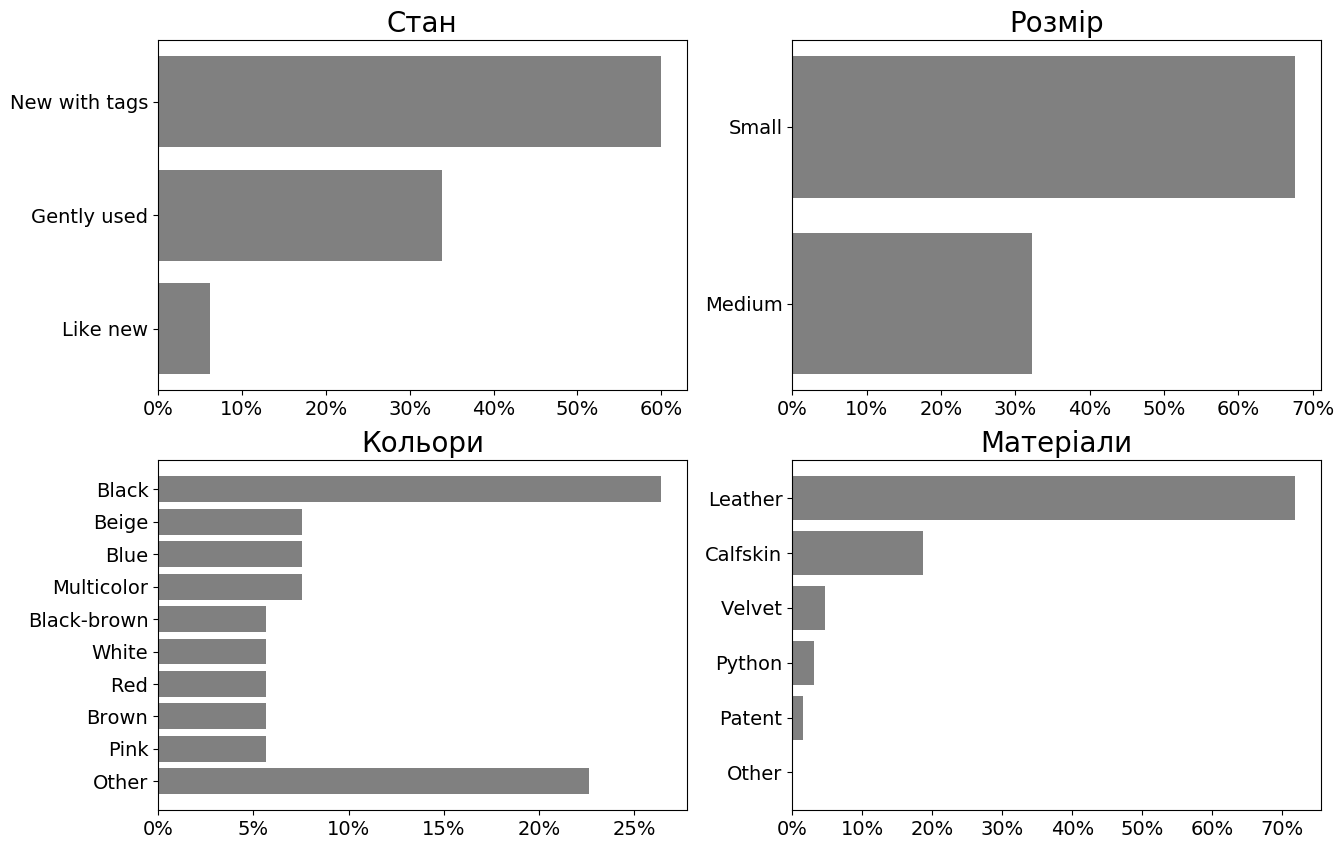

In [27]:
plt.rcdefaults()
fig = plt.figure(figsize=(15, 10))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

if size_df.shape[0] > 1:
    pl_1 = fig.add_subplot(2, 2, 2)
    pl_2 = fig.add_subplot(2, 2, 1)
    pl_3 = fig.add_subplot(2, 2, 4)
    pl_4 = fig.add_subplot(2, 2, 3)
else:
    pl_2 = fig.add_subplot(2, 2, 1)
    pl_3 = fig.add_subplot(2, 2, 3)
    pl_4 = fig.add_subplot(2, 2, 2)
    
if size_df.shape[0] > 1:
    sizes = list(size_df['size'])
    pos_size = range(len(sizes))
    y_sizes = [p*100 for p in size_df['percent']]
    pl_1.barh(y=pos_size, width=y_sizes, color='grey')
    pl_1.set_yticks(pos_size)
    pl_1.set_yticklabels(sizes)
    pl_1.invert_yaxis()
    pl_1.set_title('Розмір', fontsize=20)
    pl_1.tick_params(axis='both', which='major', labelsize=14)
    pl_1.xaxis.set_major_formatter(xticks)

conditions = list(condition_df['bags_condition'])
pos_con = range(len(conditions))
y_conditions = [p*100 for p in condition_df['percent']]
pl_2.barh(y=pos_con, width=y_conditions, color='grey')
pl_2.set_yticks(pos_con)
pl_2.set_yticklabels(conditions)
pl_2.invert_yaxis()
pl_2.set_title('Стан', fontsize=20)
pl_2.tick_params(axis='both', which='major', labelsize=14)
pl_2.xaxis.set_major_formatter(xticks)

materials = [format_materials(item) for item in list(materials_df[:9]['materials_list'])] + ['Other']
pos_mat = range(len(materials))
y_materials = [p*100 for p in materials_df['percent'][:9]] + [100 - sum(materials_df[:9]['percent'])*100]
pl_3.barh(y=pos_mat, width=y_materials, color='grey')
pl_3.set_yticks(pos_mat)
pl_3.set_yticklabels(materials)
pl_3.invert_yaxis()
pl_3.xaxis.set_major_formatter(xticks)
pl_3.tick_params(axis='both', which='major', labelsize=14)
pl_3.set_title('Матеріали', fontsize=20)

colors = list(color_df[:9]['bags_color']) + ['Other']
pos_color = range(len(colors))
y_colors = [p*100 for p in color_df['percent'][:9]] + [100 - sum(color_df[:9]['percent'])*100]
pl_4.barh(y=pos_color, width=y_colors, color='grey')
pl_4.set_yticks(pos_color)
pl_4.set_yticklabels(colors)
pl_4.invert_yaxis()
pl_4.xaxis.set_major_formatter(xticks)
pl_4.tick_params(axis='both', which='major', labelsize=14)
pl_4.set_title('Кольори', fontsize=20)


plt.show()

In [12]:
brands_dict[brand]['materials'] = dict(zip(materials_df['materials_list'], materials_df['percent']))
brands_dict[brand]['sizes'] = dict(zip(size_df['size'], materials_df['percent']))
brands_dict[brand]['colors'] = dict(zip(color_df['bags_color'], materials_df['percent']))
brands_dict[brand]['conditions'] = dict(zip(condition_df['bags_condition'], materials_df['percent']))

# Days before abandoned

In [13]:
never_sold_df = df[df['id'].isin(new_items)]
never_sold_df = never_sold_df[never_sold_df['ever_sold'] == 0] # abandoned
never_sold_df = never_sold_df[never_sold_df['sc_date_first_date'] < max_df_date - datetime.timedelta(days=30)]
never_sold_df = never_sold_df[never_sold_df.apply(lambda x: x['sc_date'] == x['sc_date_first_date'], axis = 1)]
never_sold_df = never_sold_df[never_sold_df['sc_date_last_date'] < max_df_date]
never_sold_pivot = pd.pivot_table(never_sold_df, values='lifetime', index='id', aggfunc='max').reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ea77310>]],
      dtype=object)

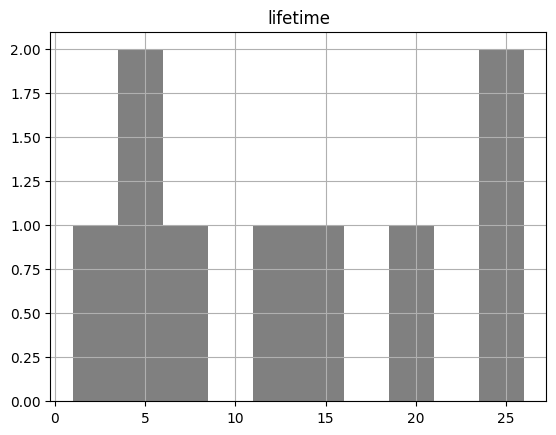

In [14]:
never_sold_pivot[never_sold_pivot['lifetime']<=30].hist('lifetime', color='grey')

In [15]:
count_dict_never_sold = defaultdict(int)
for i, row in never_sold_pivot[never_sold_pivot['lifetime']<=30].iterrows():
    count_dict_never_sold[row['lifetime']] += 1
len_pract = never_sold_pivot.shape[0]

In [16]:
opt_scale = None
min_entropy = inf
for scale in range(0, 100):
    X = numpy.random.exponential(scale, size=10000)
    X = [round(x, 0) for x in X if round(x, 0) <= 30]
    len_theor = len(X)
    count_dict_exp = defaultdict(int)
    for x in X:
        count_dict_exp[x] += 1
    pract_list = list()
    theor_list = list()
    for i in range(31):
        pract_list.append(count_dict_never_sold.get(i, 0) / len_pract)
        theor_list.append(count_dict_exp.get(i, 0) / len_theor)
    if entropy(pract_list, theor_list) < min_entropy:
        opt_scale = scale
        min_entropy = entropy(pract_list, theor_list)
print(opt_scale, min_entropy)

93 1.2930530149430512


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


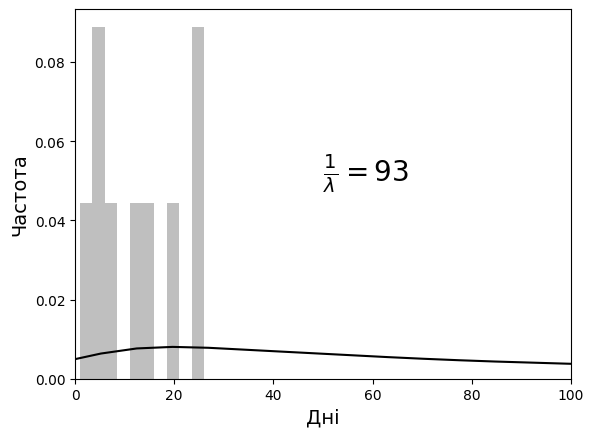

In [28]:
X = numpy.random.exponential(opt_scale, size=10000)
plt.xlabel("Дні", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xlim(0, 100)
plt.hist(never_sold_pivot[never_sold_pivot['lifetime']<=30]['lifetime'], normed=True, alpha=0.5, color='grey')
# fig1.set_ylabel("demand", fontsize=20)
plt.text(50, 0.05, r'$\frac{1}{\lambda}=$%i'%opt_scale, fontsize=20)
sns.kdeplot(X, color='black')

In [18]:
brands_dict[brand]['days_abandoned_exp_scale'] = opt_scale

# Daily number of new items

In [19]:
daily_new_items = pd.pivot_table(df[['id', 'sc_date_first_date']].drop_duplicates(), index='sc_date_first_date', 
               values='id', aggfunc='count').reset_index()['id']

In [20]:
count_dict_daily_new = defaultdict(int)
for i in list(daily_new_items):
    count_dict_daily_new[i] += 1
len_daily_pract = len(daily_new_items)

In [21]:
opt_daily = None
min_daily_entropy = inf
for scale in range(1, 20):
    X = numpy.random.exponential(scale, size=10000)
    X = [round(x, 0) for x in X]
    len_daily_theor = len(X)
    count_dict_daily_exp = defaultdict(int)
    for x in X:
        count_dict_daily_exp[x] += 1
    pract_daily_list = list()
    theor_daily_list = list()
    for i in range(int(max(count_dict_daily_exp.keys()))+1):
        pract_daily_list.append(count_dict_daily_new.get(i, 0) / len_daily_pract)
        theor_daily_list.append(count_dict_daily_exp.get(i, 0) / len_daily_theor)
    if entropy(pract_daily_list, theor_daily_list) < min_daily_entropy:
        opt_daily = scale
        min_daily_entropy = entropy(pract_daily_list, theor_daily_list)
print(opt_daily, min_daily_entropy)

2 0.46237574083414107


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


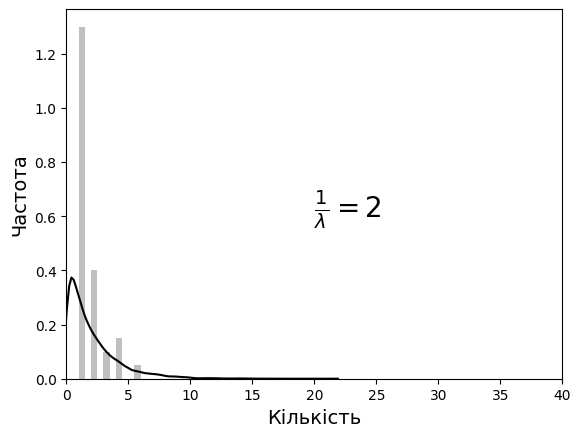

In [29]:
X = numpy.random.exponential(opt_daily, size=10000)
plt.xlabel("Кількість", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xlim(0, 40)
plt.hist(daily_new_items, normed=True, alpha=0.5, color='grey')
# fig1.set_ylabel("demand", fontsize=20)
plt.text(20, 0.6, r'$\frac{1}{\lambda}=$%i'%opt_daily, fontsize=20)
sns.kdeplot(X, color='black')

In [23]:
brands_dict[brand]['daily_new_amount'] = opt_scale

In [24]:
with open('model_patameters.pkl', 'wb') as f:
      pickle.dump(brands_dict, f)

In [25]:
print('success!')

success!
